# NetworKit User Guide

## About NetworKit

[NetworKit][networkit] is an open-source toolkit for high-performance
network analysis. Its aim is to provide tools for the analysis of large
networks in the size range from thousands to billions of edges. For this
purpose, it implements efficient graph algorithms, many of them parallel to
utilize multicore architectures. These are meant to compute standard measures
of network analysis, such as degree sequences, clustering coefficients and
centrality. In this respect, NetworKit is comparable
to packages such as [NetworkX][networkx], albeit with a focus on parallelism 
and scalability. NetworKit is also a testbed for algorithm engineering and
contains a few novel algorithms from recently published research, especially
in the area of community detection.

[networkit]: http://parco.iti.kit.edu/software/networkit.shtml 
[networkx]: http://networkx.github.com/



## Introduction

This notebook provides an interactive introduction to the features of NetworKit, consisting of text and executable code. We assume that you have read the Readme and successfully built the core library and the Python module. Code cells can be run one by one (e.g. by selecting the cell and pressing `shift+enter`), or all at once (via the `Cell->Run All` command). Try running all cells now to verify that NetworKit has been properly built and installed.


## Preparation

This notebook creates some plots. To show them in the notebook, matplotlib must be imported and we need to activate matplotlib's inline mode:

In [229]:
%matplotlib inline
import matplotlib.pyplot as plt

NetworKit is a hybrid built from C++ and Python code: Its core functionality is implemented in C++ for performance reasons, and then wrapped for Python using the Cython toolchain. This allows us to expose high-performance parallel code as a normal Python module. On the surface, NetworKit is just that and can be imported accordingly:

In [230]:
from networkit import * 

IPython lets us use familiar shell commands in a Python interpreter. Use one of them now to change into the directory of your NetworKit download:

In [231]:
cd ~/workspace/NetworKit

/Users/cls/workspace/NetworKit


## Reading and Writing Graphs

Let us start by reading a network from a file on disk: [PGPgiantcompo.graph](http://www.cc.gatech.edu/dimacs10/archive/data/clustering/PGPgiantcompo.graph.bz2). In the course of this tutorial, we are going to work on the `PGPgiantcompo` network, a social network/web of trust in which nodes are PGP keys and an edge represents a signature from one key on another. It is distributed with NetworKit as a good starting point.

There is a convenient function in the top namespace which tries to guess the input format and select the appropriate reader:

In [232]:
G = readGraph("input/PGPgiantcompo.graph", Format.METIS)
# is the same as: G = readGraph("input/PGPgiantcompo.graph", Format.METIS)

There is a large variety of formats for storing graph data in files. For NetworKit, the currently best supported format is the [METIS adjacency format](http://people.sc.fsu.edu/~jburkardt/data/metis_graph/metis_graph.html). Various example graphs in this format can be found [here](http://www.cc.gatech.edu/dimacs10/downloads.shtml).  The `readGraph` function tries to be an intelligent wrapper for various reader classes. In this example, it uses the `METISGraphReader` which is located in the `graphio` submodule, alongside other readers. These classes can also be used explicitly:

In [233]:
graphio.METISGraphReader().read("input/PGPgiantcompo.graph")
# is the same as: readGraph("input/PGPgiantcompo.graph", Format.METIS)

It is also possible to specify the format for `readGraph()` and `writeGraph()`. Supported formats can be found via `[graphio.]Format`. However, graph formats are most likely only supported as far as the NetworKit::Graph can hold and use the data. Please note, that not all graph formats are supported for reading and writing.

Thus, it is possible to use NetworKit to convert graphs between formats. Let's say I need the previously read PGP graph in the Graphviz format:

In [234]:
graphio.writeGraph(G,"output/PGPgiantcompo.graphviz",Format.GraphViz)

NetworKit also provides a function to convert graphs directly:

In [235]:
graphio.convertGraph(Format.LFR, Format.GML, "input/example.edgelist", "output/example.gml")

converted input/example.edgelist to output/example.gml


## The Graph Object

`Graph` is the central class of NetworKit. An object of this type represents an undirected, optionally weighted network. Let us inspect several of the methods which the class provides.

In [236]:
n = G.numberOfNodes()
m = G.numberOfEdges()
print(n, m)

10680 24316


In [237]:
G.toString()

b'Graph(name=PGPgiantcompo, n=10680, m=24316)'

Nodes are simply integer indices, and edges are pairs of such indices.

In [238]:
V = G.nodes()
print(V[:10])
E = G.edges()
print(E[:10])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
[(42, 11), (101, 28), (111, 92), (128, 87), (141, 0), (165, 125), (169, 111), (176, 143), (187, 38), (192, 105)]


In [239]:
G.hasEdge(42,11)

True

This network is unweighted, meaning that each edge has the default weight of 1.

In [240]:
G.weight(42,11)

1.0

## Connected Components

A connected component is a set of nodes in which each pair of nodes is connected by a path. The following function determines the connected components of a graph:

In [241]:
cc = components.ConnectedComponents(G)
cc.run()
print("number of components ", cc.numberOfComponents())
v = 0
print("component of node ", v , ": " , cc.componentOfNode(0))
#print("map of component sizes: ", cc.getComponentSizes())

number of components  1
component of node  0 :  0


## Degree Distribution

Node degree, the number of edges connected to a node, is one of the most studied properties of networks. Types of networks are often characterized in terms of their distribution of node degrees. We obtain and visualize the degree distribution of our example network as follows.  

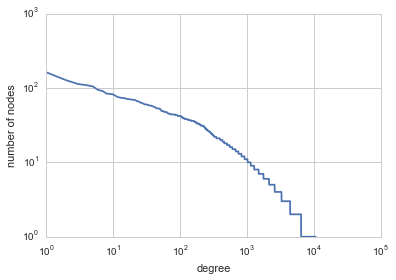

In [242]:
dd = sorted(centrality.DegreeCentrality(G).run().scores(), reverse=True)
plt.xscale("log")
plt.xlabel("degree")
plt.yscale("log")
plt.ylabel("number of nodes")
plt.plot(dd)

## Search and Shortest Paths

A simple breadth-first search from a starting node can be performed as follows:

In [243]:
v = 0
bfs = graph.BFS(G, v)
bfs.run()

bfsdist = bfs.getDistances()

The return value is a list of distances from `v` to other nodes - indexed by node id. For example, we can now calculate the mean distance from the starting node to all other nodes:

In [244]:
sum(bfsdist) / len(bfsdist)

11.339044943820225

Similarly, Dijkstra's algorithm yields shortest path distances from a starting node to all other nodes in a weighted graph. Because `PGPgiantcompo` is an unweighted graph, the result is the same here:

In [245]:
dijkstra = graph.Dijkstra(G, v)
dijkstra.run()
spdist = dijkstra.getDistances()
sum(spdist) / len(spdist)

11.339044943820225

## Core Decomposition

A $k$-core decomposition of a graph is performed by successicely peeling away nodes with degree less than $k$. The remaining nodes form the $k$-core of the graph.

In [246]:
K = readGraph("input/karate.graph",Format.METIS)
coreDec = centrality.CoreDecomposition(K)
coreDec.run()

Core decomposition assigns a core number to each node, being the maximum $k$ for which a node is contained in the $k$-core. For this small graph, core numbers have the following range:

In [247]:
set(coreDec.scores())

{1.0, 2.0, 3.0, 4.0}

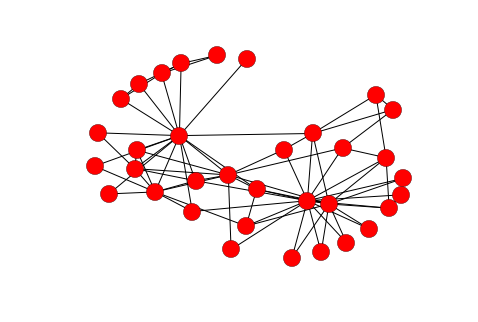

In [248]:
viztasks.drawGraph(K, nodeSizes=[(k**2)*20 for k in coreDec.scores()])

## Community Detection

This section demonstrates the community detection capabilities of NetworKit. Community detection is concerned with identifying groups of nodes which are significantly more densely connected to eachother than to the rest of the network.

Code for community detection is contained in the `community` module. The module provides a top-level function to quickly perform community detection with a suitable algorithm and print some stats about the result.

In [249]:
community.detectCommunities(G)

PLM(balanced,pc) detected communities in 0.043380022048950195 [s]
solution properties:
-------------------  ----------
# communities        101
min community size     6
max community size   689
avg. community size  105.743
modularity             0.881017
-------------------  ----------


The function prints some statistics and returns the partition object representing the communities in the network as an assignment of node to community label. Let's capture this result of the last function call.

In [250]:
communities = community.detectCommunities(G)

PLM(balanced,pc) detected communities in 0.05588078498840332 [s]
solution properties:
-------------------  ---------
# communities        101
min community size     6
max community size   697
avg. community size  105.743
modularity             0.88209
-------------------  ---------


*Modularity* is the primary measure for the quality of a community detection solution. The value is in the range `[-0.5,1]` and usually depends both on the performance of the algorithm and the presence of distinctive community structures in the network.

In [251]:
community.Modularity().getQuality(communities, G)

0.8820896116835413

### The Partition Data Structure

The result of community detection is a partition of the node set into disjoint subsets. It is represented by the `Partition` data strucure, which provides several methods for inspecting and manipulating a partition of a set of elements (which need not be the nodes of a graph).

In [252]:
type(communities)

_NetworKit.Partition

In [253]:
print("{0} elements assigned to {1} subsets".format(communities.numberOfElements(), communities.numberOfSubsets()))


10680 elements assigned to 101 subsets


In [254]:
print("the biggest subset has size {0}".format(max(communities.subsetSizes())))

the biggest subset has size 697


The contents of a partition object can be written to file in a simple format, in which each line *i* contains the subset id of node *i*.

In [255]:
community.writeCommunities(communities, "output/communties.partition")

wrote communities to: output/communties.partition


### Choice of Algorithm

The community detection function used a good default choice for an algorithm: *PLM*, our parallel implementation of the well-known Louvain method. It yields a high-quality solution at reasonably fast running times. Let us now apply a variation of this algorithm.

In [256]:
community.detectCommunities(G, algo=community.PLP(G))

PLP detected communities in 0.00993490219116211 [s]
solution properties:
-------------------  -----------
# communities        1007
min community size      2
max community size    476
avg. community size    10.6058
modularity              0.794773
-------------------  -----------


We have switched on refinement, and we can see how modularity is slightly improved. For a small network like this, this takes only marginally longer.

### Visualizing the Result

We can easily plot the distribution of community sizes as follows. While the distribution is skewed, it does not seem to fit a power-law, as shown by a log-log plot.

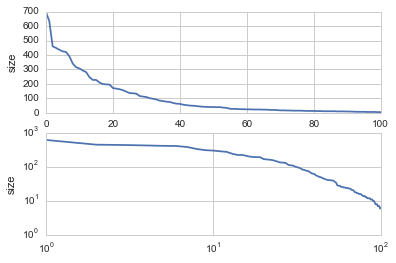

In [257]:
sizes = communities.subsetSizes()
sizes.sort(reverse=True)
ax1 = plt.subplot(2,1,1)
ax1.set_ylabel("size")
ax1.plot(sizes)

ax2 = plt.subplot(2,1,2)
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_ylabel("size")
ax2.plot(sizes)

## Subgraph

NetworKit supports the creation of Subgraphs depending on an original graph and a set of nodes. This might be useful in case you want to analyze certain communities of a graph. Let's say that community 2 of the above result is of further interest, so we want a new graph that consists of nodes and intra cluster edges of community 2.

In [258]:
from networkit.graph import Subgraph
c2 = communities.getMembers(2)
sg = Subgraph()
g2 = sg.fromNodes(G,c2)

In [259]:
communities.subsetSizeMap()[2]

164

In [260]:
g2.numberOfNodes()

164

As we can see, the number of nodes in our subgraph matches the number of nodes of community 2. The subgraph can be used like any other graph object, e.g. further community analysis:

In [261]:
communities2 = community.detectCommunities(g2)

PLM(balanced,pc) detected communities in 0.024367094039916992 [s]
solution properties:
-------------------  ---------
# communities        11
min community size    5
max community size   34
avg. community size  14.9091
modularity            0.750415
-------------------  ---------


## Centrality

[Centrality](http://en.wikipedia.org/wiki/Centrality) measures the relative importance of a node within a graph. Code for centrality analysis is grouped into the `centrality` module.

### Betweenness Centrality

We implement Brandes' algorithm for the exact calculation of betweenness centrality. While the algorithm is efficient, it still needs to calculate shortest paths between all pairs of nodes, so its scalability is limited. We demonstrate it here on the small Karate club graph.  

In [262]:
K = readGraph("input/karate.graph", Format.METIS)

In [263]:
bc = centrality.Betweenness(K)
bc.run()

We have now calculated centrality values for the given graph, and can retrieve them either as an ordered ranking of nodes or as a list of values indexed by node id. 

In [264]:
bc.ranking()[:10] # the 10 most central nodes

[(0, 462.14285714285717),
 (33, 321.10317460317464),
 (32, 153.38095238095238),
 (2, 151.70158730158727),
 (31, 146.0190476190476),
 (8, 59.05873015873016),
 (1, 56.95714285714285),
 (13, 48.43174603174603),
 (19, 34.29365079365079),
 (6, 31.666666666666664)]

### Approximation of Betweenness

Since exact calculation of betweenness scores is often out of reach, NetworKit provides an approximation algorithm based on path sampling. Here we estimate betweenness centrality in `PGPgiantcompo`, with a probabilistic guarantee that the error is no larger than an additive constant $\epsilon$.

In [265]:
abc = centrality.ApproxBetweenness(G, epsilon=0.1)
abc.run()

The 10 most central nodes according to betweenness are then

In [266]:
abc.ranking()[:10]

[(1143, 0.11778846153846151),
 (7297, 0.11538461538461536),
 (6655, 0.09855769230769229),
 (6555, 0.09134615384615384),
 (604, 0.06730769230769232),
 (3156, 0.060096153846153855),
 (6932, 0.060096153846153855),
 (7369, 0.057692307692307696),
 (6744, 0.05288461538461539),
 (2258, 0.04567307692307693)]

### Eigenvector Centrality and PageRank

Eigenvector centrality and its variant PageRank assign relative importance to nodes according to their connections, incorporating the idea that edges to high-scoring nodes contribute more. PageRank is a version of eigenvector centrality which introduces a damping factor, modeling a random web surfer which at some point stops following links and jumps to a random page. In PageRank theory, centrality is understood as the probability of such a web surfer to arrive on a certain page. Our implementation of both measures is based on parallel power iteration, a relatively simple eigensolver.

In [267]:
# Eigenvector centrality
ec = centrality.EigenvectorCentrality(K)
ec.run()
ec.ranking()[:10] # the 10 most central nodes

[(33, 0.37335860763538437),
 (0, 0.3554879627576304),
 (2, 0.31719212126079693),
 (32, 0.308641699961726),
 (1, 0.2659584485486244),
 (8, 0.2274061452435449),
 (13, 0.22647475684342064),
 (3, 0.2111796960531623),
 (31, 0.19103658572493037),
 (30, 0.1747599501690216)]

In [268]:
# PageRank
pr = centrality.PageRank(K, 1e-6)
pr.run()
pr.ranking()[:10] # the 10 most central nodes

[(33, 0.02941190490185556),
 (0, 0.029411888071820155),
 (32, 0.02941184486730034),
 (1, 0.02941180477938106),
 (2, 0.02941179873364914),
 (3, 0.029411771282676906),
 (31, 0.029411770725212477),
 (5, 0.029411768995095993),
 (6, 0.029411768995095993),
 (23, 0.029411763985014328)]

## NetworkX Compatibility

[NetworkX](http://en.wikipedia.org/wiki/Centrality) is a popular Python package for network analysis. To let both packages complement eachother, and to enable the adaptation of existing NetworkX-based code, we support the conversion of the respective graph data structures.

In [269]:
import networkx as nx
nxG = nxadapter.nk2nx(G) # convert from NetworKit.Graph to networkx.Graph
print(nx.degree_assortativity_coefficient(nxG))

0.238211371708


## Generating Graphs

An important subfield of network science is the design and analysis of generative models. A variety of generative models have been proposed with the aim of reproducing one or several of the properties we find in real-world complex networks. NetworKit includes generator algorithms for several of them.

The **Erdös-Renyi model** is the most basic random graph model, in which each edge exists with the same uniform probability. NetworKit provides an efficient generator:

In [270]:
ERG = generators.ErdosRenyiGenerator(1000, 0.1).generate()

A simple way to generate a **random graph with community structure** is to use the `ClusteredRandomGraphGenerator`. It uses a simple variant of the Erdös-Renyi model: The node set is partitioned into a given number of subsets. Nodes within the same subset have a higher edge probability.

In [271]:
CRG = generators.ClusteredRandomGraphGenerator(200, 4, 0.2, 0.002).generate()

In [272]:
community.detectCommunities(CRG)

PLM(balanced,pc) detected communities in 0.0016009807586669922 [s]
solution properties:
-------------------  ---------
# communities         4
min community size   41
max community size   56
avg. community size  50
modularity            0.706928
-------------------  ---------


The **Chung-Lu model** (also called **configuration model**) generates a random graph which corresponds to a given degree sequence, i.e. has the same expected degree sequence. It can therefore be used to replicate some of the properties of a given real networks, while others are not retained, such as high clustering and the specific community structure.

In [273]:
degreeSequence = [G.degree(v) for v in G.nodes()]
clgen = generators.ChungLuGenerator(degreeSequence)


## Settings

In this section we discuss global settings.

### Logging

When using NetworKit from the command line, the verbosity of console output can be controlled via several loglevels, from least to most verbose: `FATAL`, `ERROR`, `WARN`, `INFO`, `DEBUG` and `TRACE`. (Currently, logging is only available on the console and not visible in the IPython Notebook). 

In [274]:
getLogLevel() # the default loglevel

'ERROR'

In [275]:
setLogLevel("TRACE") # set to most verbose mode
setLogLevel("ERROR") # set back to default

Please note, that the default build setting is optimized (`--optimize=Opt`) and thus, every LOG statement below INFO is removed. If you need DEBUG and TRACE statements, please build the extension module by appending `--optimize=Dbg` when calling the setup script.

### Parallelism

The degree of parallelism can be controlled and monitored in the following way:

In [276]:
setNumberOfThreads(4) # set the maximum number of available threads

In [277]:
getMaxNumberOfThreads() # see maximum number of available threads

4

In [278]:
getCurrentNumberOfThreads() # the number of threads currently executing

1

## Support

NetworKit is an open-source project that improves with suggestions and contributions from its users. The email list `networkit@ira.uni-karlsruhe.de` is the place for general discussion and questions. Also feel free to contact the authors with questions on how NetworKit can be applied to your research.

-- [Christian L. Staudt](mailto:christian.staudt@kit.edu) and [Henning Meyerhenke](mailto:meyerhenke@kit.edu)